In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose # descomposicion de los datos
from statsmodels.tsa.stattools import adfuller, acf, pacf # Test de Dickey-Fuller (estacionaridad)
from statsmodels.tsa.stattools import acf, pacf # Función de autocorrelación/ autocorrelación parcial (parámetros modelo ARIMA)
from statsmodels.tsa.arima.model import ARIMA # modelo para el forecating


Datos de los gases de efecto invernadero Globales (datos de NOAA) 

- <b>Ref</b>: Dr. Pieter Tans, NOAA/GML (gml.noaa.gov/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

https://gml.noaa.gov/ccgg/trends/data.html

In [2]:
def read_data_annual(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df=df.set_index("year")
    df.index = pd.to_datetime(df.index,format='%Y')
    df.rename(columns={"mean": gas},inplace=True)
    return df

def read_data_monthly(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df=df.set_index("date")
    df.drop("year",axis=1,inplace=True)
    df.drop("month",axis=1,inplace=True)
    df.drop("decimal",axis=1,inplace=True)
    # Comparación datos originales y predichos por el modelo para el CO2
    if gas == "CO2":
        df.rename(columns={"average": gas},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
    else:
        df.rename(columns={"average": gas,"average_unc":"unc"},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
        df.drop("trend_unc",axis=1,inplace=True)
    return df

In [3]:
# Leemos los ficheros y modificamos las tablas para crearlas como nosotros queremos
data_CO2_mensual=read_data_monthly("tablas_ini/NOAAdata_CO2_monthly.csv","CO2")
data_CO2_anual=read_data_annual("tablas_ini/NOAAdata_CO2_annual.csv","CO2")

data_N2O_mensual=read_data_monthly("tablas_ini/NOAAdata_N2O_monthly.csv","N2O")
data_N2O_anual=read_data_annual("tablas_ini/NOAAdata_N2O_annual.csv","N2O")

data_CH4_mensual=read_data_monthly("tablas_ini/NOAAdata_CH4_monthly.csv","CH4")
data_CH4_anual=read_data_annual("tablas_ini/NOAAdata_CH4_annual.csv","CH4")

data_SF6_mensual=read_data_monthly("tablas_ini/NOAAdata_SF6_monthly.csv","SF6")
data_SF6_anual=read_data_annual("tablas_ini/NOAAdata_SF6_annual.csv","SF6")

In [4]:
# Unimos todas las tablas
data_anual = pd.concat([data_CO2_anual, data_N2O_anual,data_CH4_anual,data_SF6_anual], axis=1)
data_mensual = pd.concat([data_CO2_mensual, data_N2O_mensual,data_CH4_mensual,data_SF6_mensual], axis=1)


In [5]:
# Extraemos de la fecha por un lado los meses y por otro los años, guardamos la información de dos nuevas columnas
data_month=data_mensual.reset_index()
data_anual_temp=data_anual.reset_index()

data_month['month'] = data_month['date'].dt.month
data_month['year'] = data_month['date'].dt.year

data_anual_temp['año'] = data_anual_temp['year'].dt.year

data_month=data_month.set_index("date")
# data_temp=data_anual.set_index("year")

#### Estadística de los datos

In [6]:
# estadistica de los datos
data_anual.describe()

CO2           unc         N2O        unc          CH4  \
count   41.000000  4.100000e+01   20.000000  20.000000    37.000000   
mean   371.525854  1.000000e-01  324.013500   0.126000  1769.115676   
std     21.880138  1.405019e-17    5.273355   0.013139    57.565462   
min    338.910000  1.000000e-01  316.360000   0.100000  1644.680000   
25%    354.050000  1.000000e-01  319.592500   0.120000  1736.490000   
50%    368.960000  1.000000e-01  323.700000   0.125000  1773.360000   
75%    388.760000  1.000000e-01  328.365000   0.140000  1803.110000   
max    412.440000  1.000000e-01  333.030000   0.150000  1879.100000   

             unc        SF6        unc  
count  37.000000  23.000000  23.000000  
mean    0.599459   6.923478   0.003522  
std     0.089503   1.896033   0.001039  
min     0.420000   4.210000   0.002000  
25%     0.540000   5.340000   0.003000  
50%     0.580000   6.750000   0.004000  
75%     0.660000   8.415000   0.004000  
max     0.810000  10.270000   0.006000

In [7]:
# estadistica de los datos
data_mensual.describe()

CO2         N2O         unc          CH4         unc  \
count  502.000000  249.000000  249.000000   459.000000  459.000000   
mean   372.381733  324.388755   -0.196386  1769.844880    0.856209   
std     22.281381    5.407204    1.772035    60.633767    1.456974   
min    337.050000  316.100000   -9.900000  1625.900000   -9.900000   
25%    354.000000  319.700000    0.100000  1736.650000    0.900000   
50%    369.680000  324.100000    0.100000  1774.600000    1.000000   
75%    390.265000  328.900000    0.100000  1807.150000    1.100000   
max    416.080000  334.400000    0.200000  1900.500000    2.900000   

              SF6         unc  
count  291.000000  291.000000  
mean     6.978522   -0.266440  
std      1.964954    1.622506  
min      4.000000   -9.900000  
25%      5.245000    0.005000  
50%      6.770000    0.006000  
75%      8.615000    0.006000  
max     10.690000    0.013000

array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'N2O'}>],
       [<AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'SF6'}>]], dtype=object)

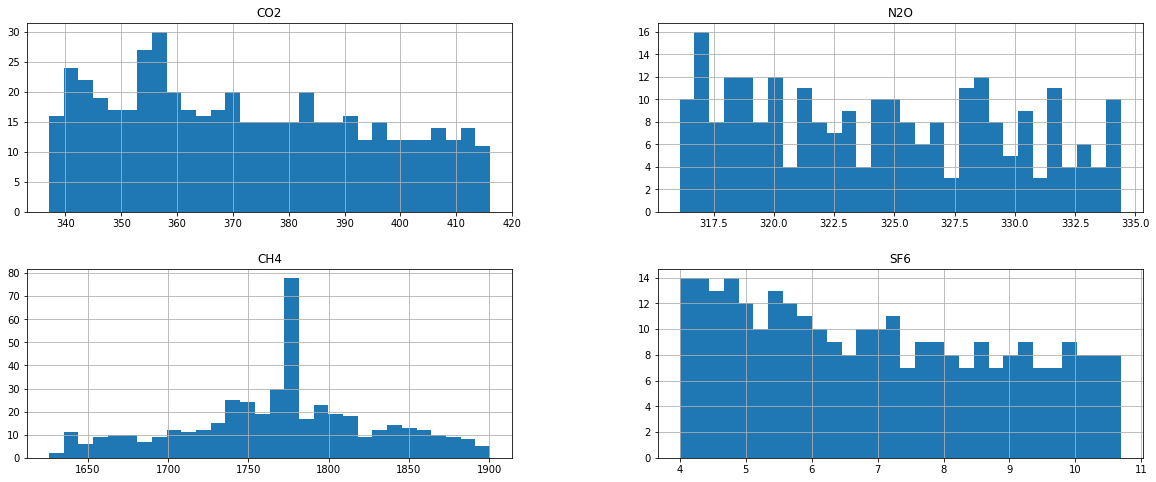

In [8]:
# Histograma de los datos
data_mensual.hist(column=["CO2","N2O","CH4","SF6"],bins=30, figsize=(20, 8))

#### Representación de los datos

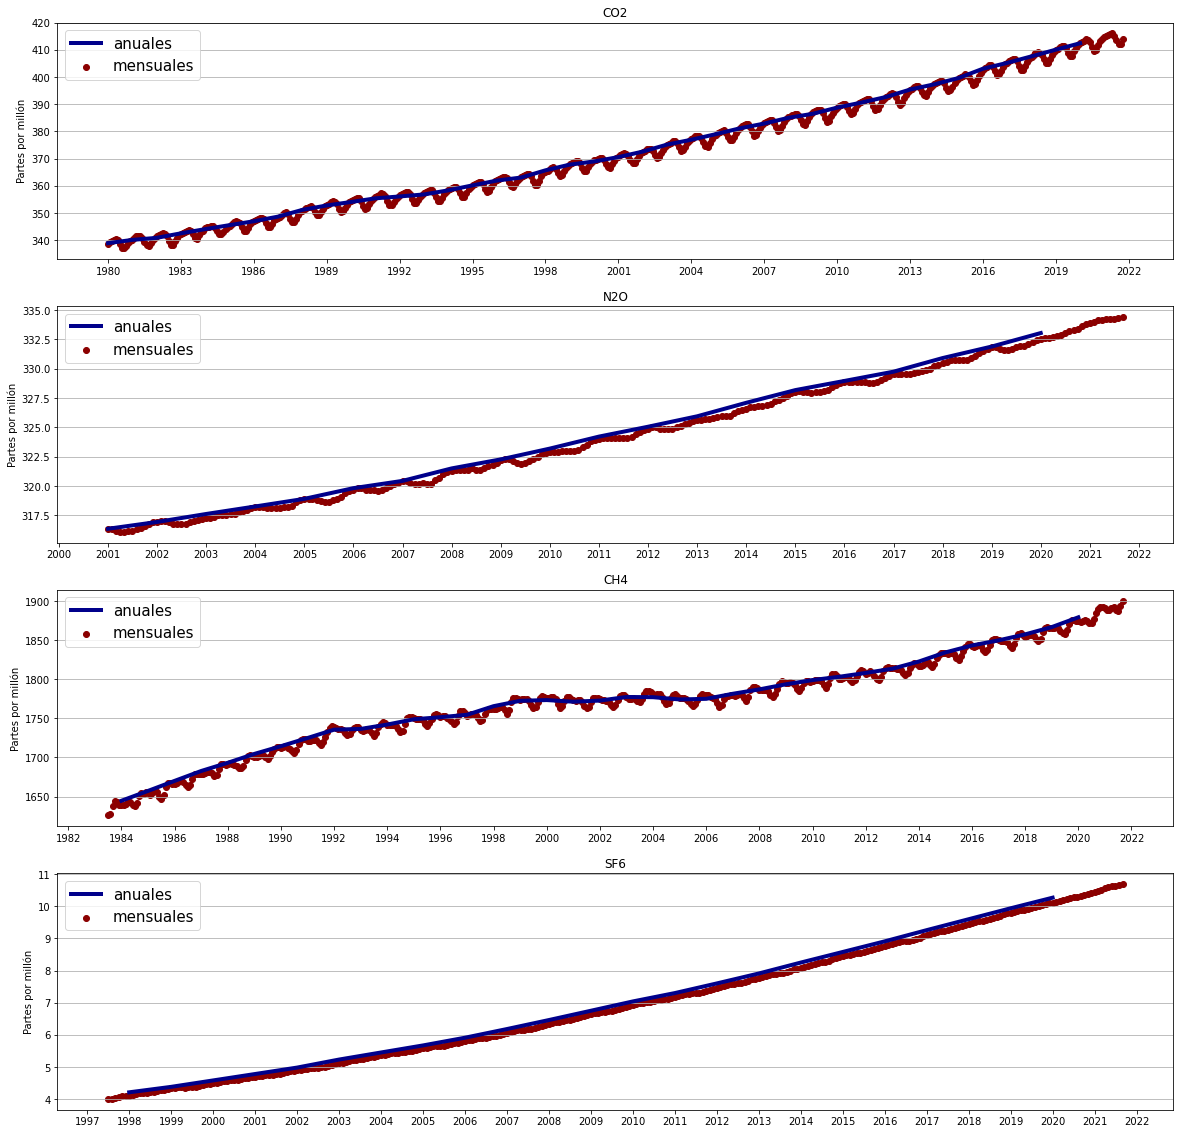

In [9]:
# Representación de los datos mensuales y anuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)

b=["CO2","N2O","CH4","SF6"]
year=[3,1,2,1]

for i in range(len(b)):

    ax[i].scatter(data_mensual.index,data_mensual[b[i]],c="darkred",label="mensuales")
    ax[i].plot(data_anual.index,data_anual[b[i]],c="darkblue",lw=4,label="anuales")

    ax[i].set_title(b[i])
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Partes por millón')
    ax[i].legend(fontsize=15, loc="upper left")

    ax[i].xaxis.set_major_locator(mdates.YearLocator(year[i]))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].tick_params(axis='x', rotation=0)

#### Distribución de los datos

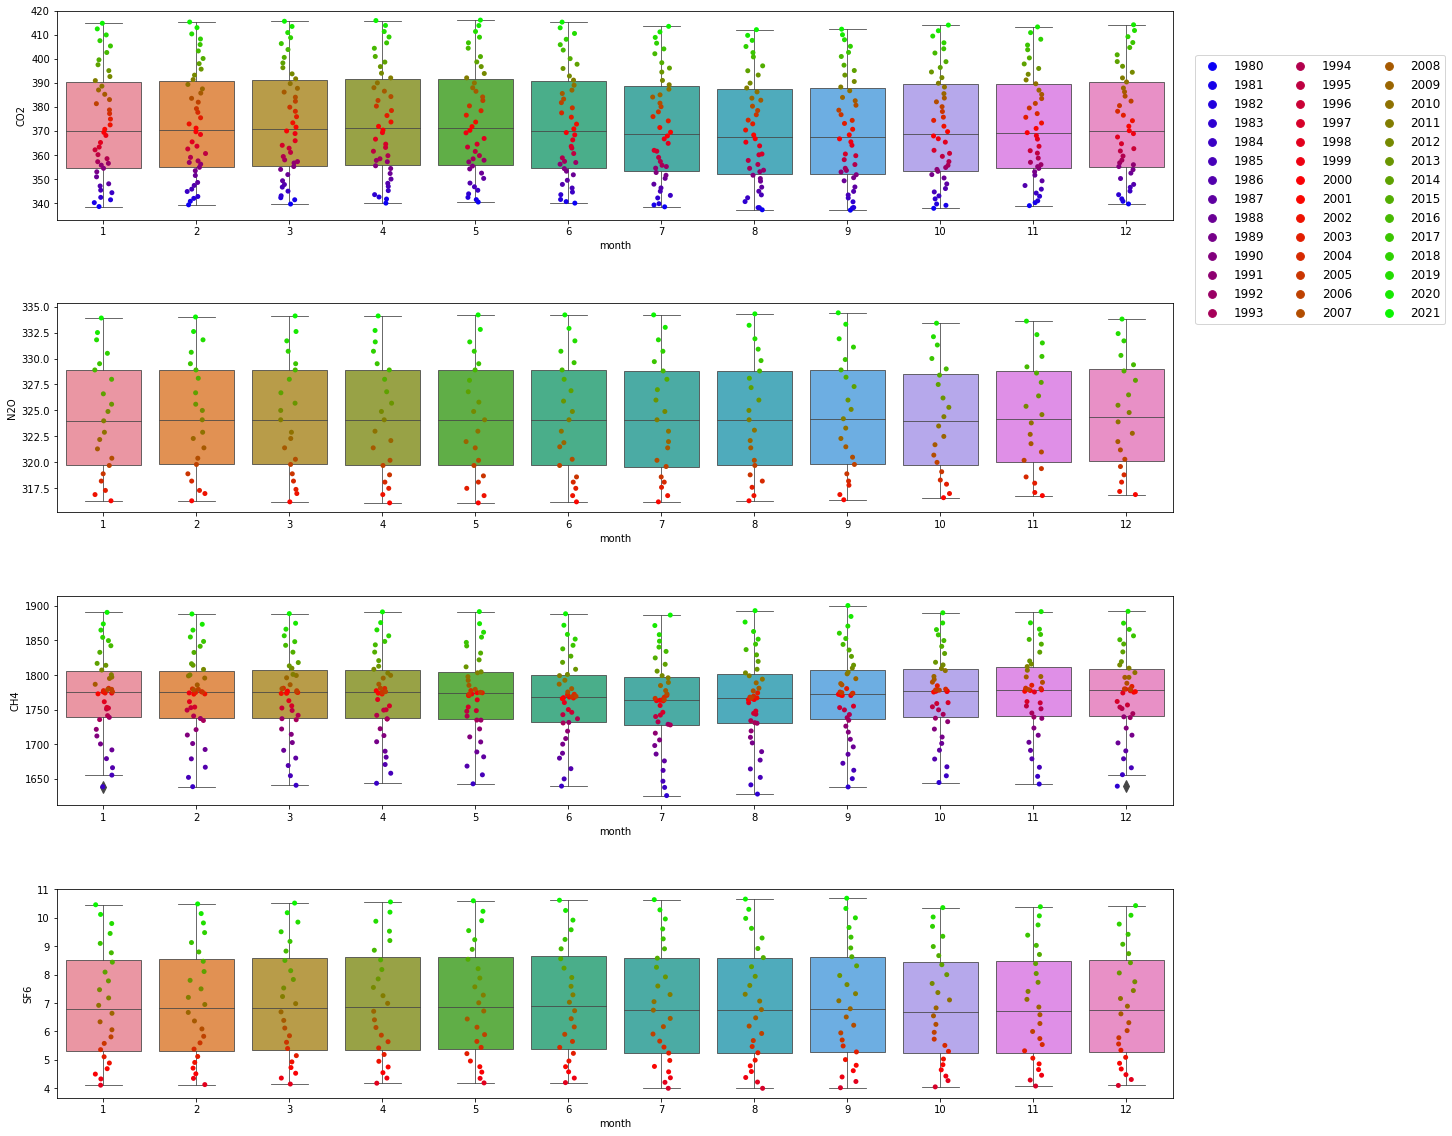

In [10]:
# Boxplot de los datos de cada gas para cada mes + scatterplot de los datos mensuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    sns.stripplot(x=data_month["month"], y=data_month[a[i]],hue=data_month["year"],ax=ax[i],size=5,jitter=True,
                 palette='brg')
    sns.boxplot(x=data_month["month"], y=data_month[a[i]],ax=ax[i],fliersize=8,linewidth=0.8)

    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend('',frameon=False)
    ax[0].legend(handles, labels,loc=(1.02,-0.5),fontsize=12,ncol=3)

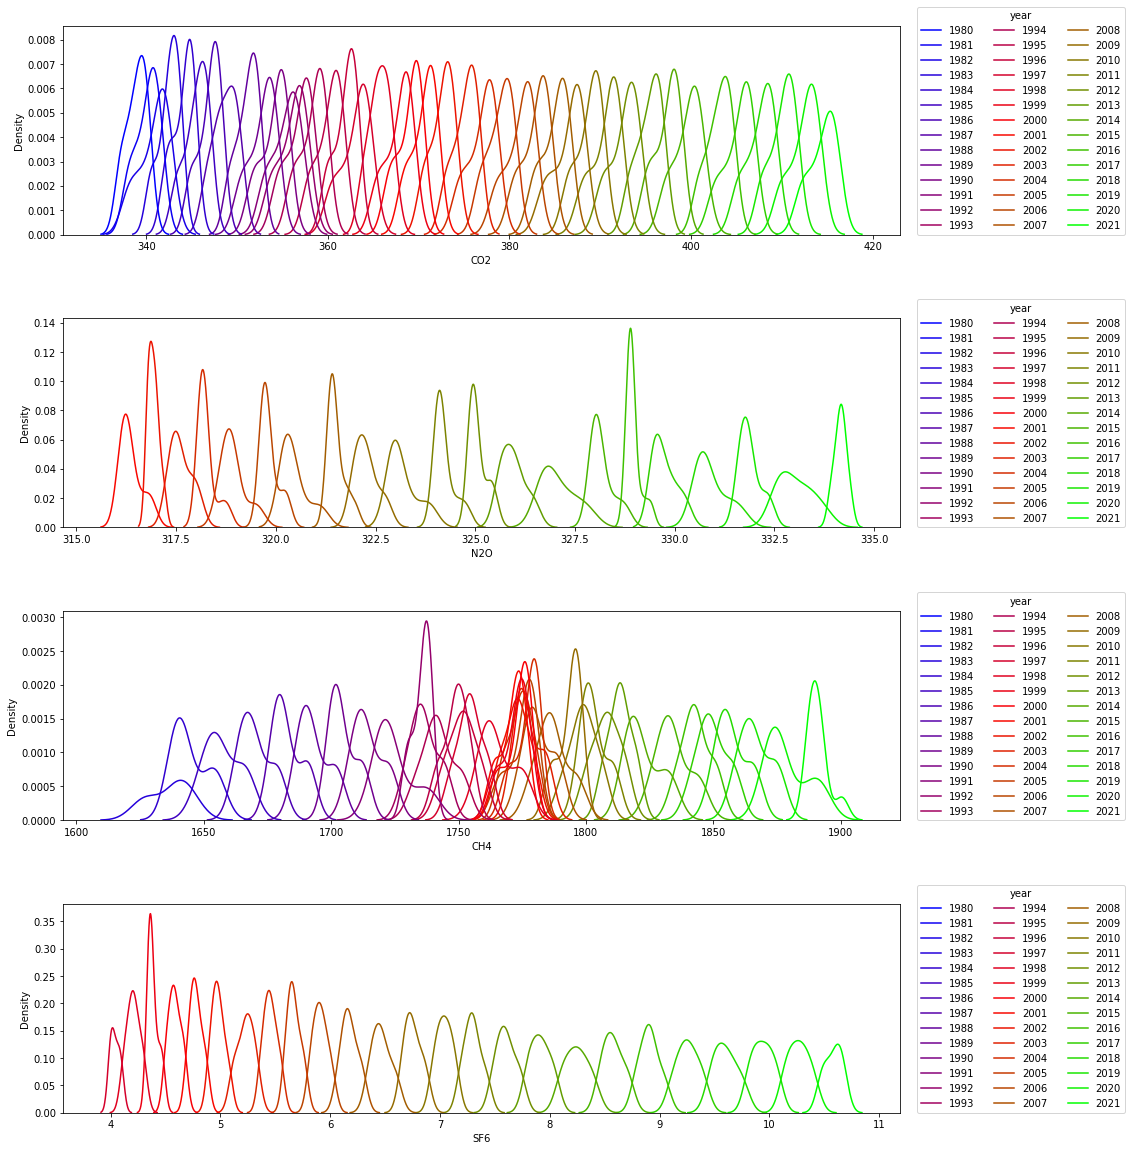

In [11]:
# Representación de la distrubución (KDE) por años  de los gases medidos cada mes
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    ax = fig.add_subplot(4, 1, i+1)
    plot=sns.kdeplot(x=data_month[a[i]].dropna(axis=0),hue=data_month["year"].dropna(axis=0),
                     palette='brg',ax=ax,warn_singular=False)
    sns.move_legend(ax, ncol=3, loc=(1.02,0))


#### Estudio de la estacionaridad

In [12]:
# Función en la que estimamos los diferentes parámetros y plots para hacer el estudio de la estacionaridad
def test_stacionary(df,gas,ventana,metodo,tendencia):
       
    print("-- "+str(gas)+" --> "+str(metodo)+":\n") 
    
    # Separamos los cálculos si eliminamos la tendencia o no
    if tendencia == "yes": # Eliminamos la tendencia usando la média móvil y la média móvil promediada exponencialmente
        
        df_log=np.log(df[["CO2","N2O","CH4","SF6"]])

        # Eliminamos la tendencia usando el logaritmo de los datos y sustrayendo la media móvil con una ventana de 12
        df_mov_avg=df_log.rolling(12).mean() # Cálculo de la medía móvil
        df1=df_log-df_mov_avg # Sustraemos los datos

        # Eliminamos la tendencia usandola média móvil ponderada exponencialmente con un decaimiento en terminos de vida 
        # média de 12, ya que el estudio de estacionaridad es mejor.
        df_mov_avg_exp=df_log.ewm(halflife=12).mean()
        df2=df_log-df_mov_avg_exp
        
        # Cálculo de la média móvil y la desviación std. móvil
        df1_temp=df1[["CO2","N2O","CH4","SF6"]]
        df1_mov_avg=df1_temp.rolling(ventana).mean()
        df1_mov_std=df1_temp.rolling(ventana).std()
        
        df2_temp=df2[["CO2","N2O","CH4","SF6"]]
        df2_mov_avg=df2_temp.rolling(ventana).mean()
        df2_mov_std=df2_temp.rolling(ventana).std()
        
        # Representamos los datos junto con la média móvil y la desviación std. móvil
        fig = plt.figure(figsize=(20,8))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2=ax1.twinx()

        plot1=ax1.plot(df1.index,df1[gas],c='blue',label="datos mensuales",lw=3)
        plot2=ax1.plot(df1_mov_avg.index,df1_mov_avg[gas],"-",label="promedio",c="black",lw=3)
        plot3=ax2.plot(df1_mov_std.index,df1_mov_std[gas],"-",label="desviación std.",c="red",lw=3)
        ax1.set_title(str(gas)+" -- usando média móvil")
        ax2.set_ylim((0,0.1))
        

        ax3 = fig.add_subplot(1, 2, 2)
        ax4 = ax3.twinx()
        
        plot1=ax3.plot(df2.index,df2[gas],c='blue',label="datos mensuales",lw=3)
        plot2=ax3.plot(df2_mov_avg.index,df2_mov_avg[gas],"-",label="promedio",c="black",lw=3)
        plot3=ax4.plot(df2_mov_std.index,df2_mov_std[gas],"-",label="desviación std.",c="red",lw=3)
        ax3.set_title(str(gas)+" -- usando medía móvil ponderada exponencial")
        ax4.set_ylim((0,0.1))       

        lns1 = plot1
        labs1 = [l.get_label() for l in lns1]
        lns2 = plot2+plot3
        labs2 = [l.get_label() for l in lns2]

        ax3.legend(lns1,labs1,loc=(1.05,0.8),fontsize=14, fancybox=True, shadow=True)
        ax3.legend(lns2,labs2,loc=(1.05,0.5),fontsize=14, fancybox=True, shadow=True)
        ax3.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(ventana)+": \n",prop={'size':16})
        plt.show()
        
        # Test de Dickey-Fuller:
        dftest1 = adfuller(df1[gas].dropna(axis=0), autolag='AIC')
        dfoutput1 = pd.Series(dftest1[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest1[4].items():
            dfoutput1['Critical Value (%s)'%key] = value
        print("\n-- Test de Dickey-Fuller (médias móviles):")
        print(dfoutput1) 
        
        dftest2 = adfuller(df2[gas].dropna(axis=0), autolag='AIC')
        dfoutput2 = pd.Series(dftest2[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest2[4].items():
            dfoutput2['Critical Value (%s)'%key] = value
        print("\n-- Test de Dickey-Fuller (médias móviles ponderadas exponencialmente):")
        print(dfoutput2)
        
        return df1[gas],df2[gas]
        
    else: # no se elimina la tendencia (datos originales)
        
        # Cálculo de las propiedades la média móvil y la desviación std. móvil
        df_temp=df[["CO2","N2O","CH4","SF6"]]
        df_temp=df
        df_mov_avg=df_temp.rolling(ventana).mean()
        df_mov_std=df_temp.rolling(ventana).std()
        
        # Representamos los datos junto con la média móvil y la desviación std. móvil
        fig, ax1 = plt.subplots(1,1,figsize=(20,5))
        ax2=ax1.twinx()

        plot1=ax1.plot(df.index,df[gas],c='blue',label="datos mensuales",lw=3)
        plot2=ax1.plot(df_mov_avg.index,df_mov_avg[gas],"-",label="promedio",c="black",lw=3)
        plot3=ax2.plot(df_mov_std.index,df_mov_std[gas],"-",label="desviación std.",c="red",lw=3)
        ax1.set_title(str(gas)+" --  datos originales")
        ax1.set_ylabel('Partes por millon')
        ax2.set_ylabel('Partes por millon')
        ax1.yaxis.grid()
        ax2.set_ylim((0,20))

        lns1 = plot1
        labs1 = [l.get_label() for l in lns1]
        lns2 = plot2+plot3
        labs2 = [l.get_label() for l in lns2]

        ax1.legend(lns1,labs1,loc=(1.05,0.8),fontsize=14, fancybox=True, shadow=True)
        ax2.legend(lns2,labs2,loc=(1.05,0.5),fontsize=14, fancybox=True, shadow=True)
        ax2.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(ventana)+": \n",prop={'size':16})
        plt.show()
    
        # Test de Dickey-Fuller:
        dftest = adfuller(df[gas].dropna(axis=0), autolag='AIC')
        dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print("\n-- Test de Dickey-Fuller -- datos originales:")
        print(dfoutput)  
        


-- CO2 --> datos originales:



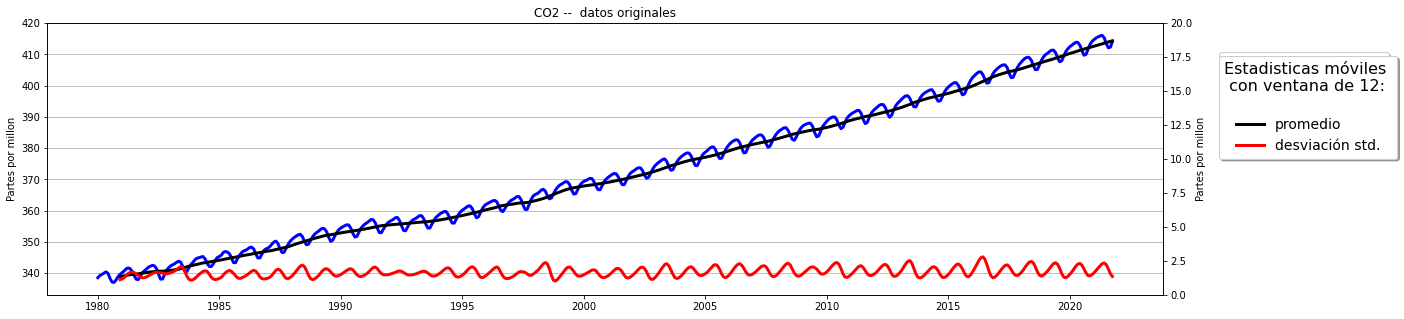


-- Test de Dickey-Fuller -- datos originales:
Test Statistic                   3.263791
p-value                          1.000000
#Lags Used                      18.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64


In [13]:
# Estudio de la estacionaridad para los datos de CO2:
# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,5),sharex=False)
test_stacionary(data_mensual,"CO2",12, "datos originales","no")

-- N2O --> datos originales:



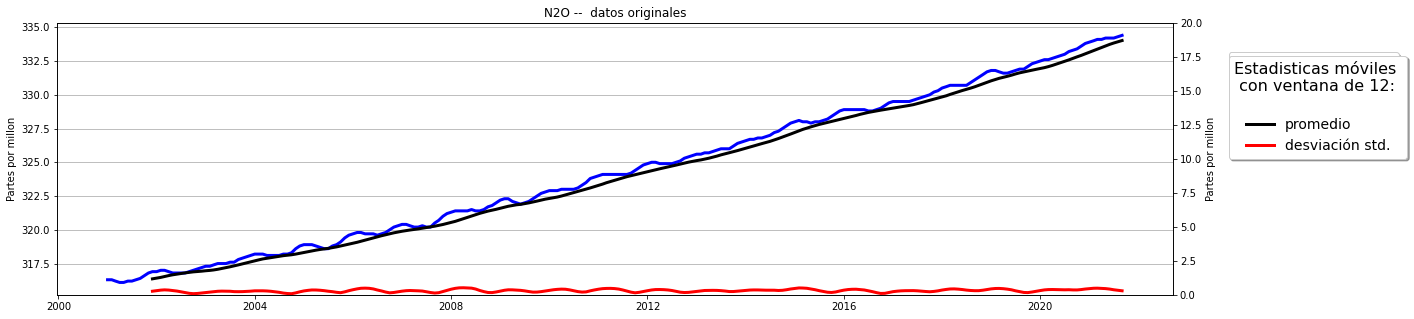


-- Test de Dickey-Fuller -- datos originales:
Test Statistic                   2.421504
p-value                          0.999020
#Lags Used                      13.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [14]:
# Estudio de la estacionaridad para los datos de N2O:
test_stacionary(data_mensual,"N2O",12, "datos originales","no")

-- CH4 --> datos originales:



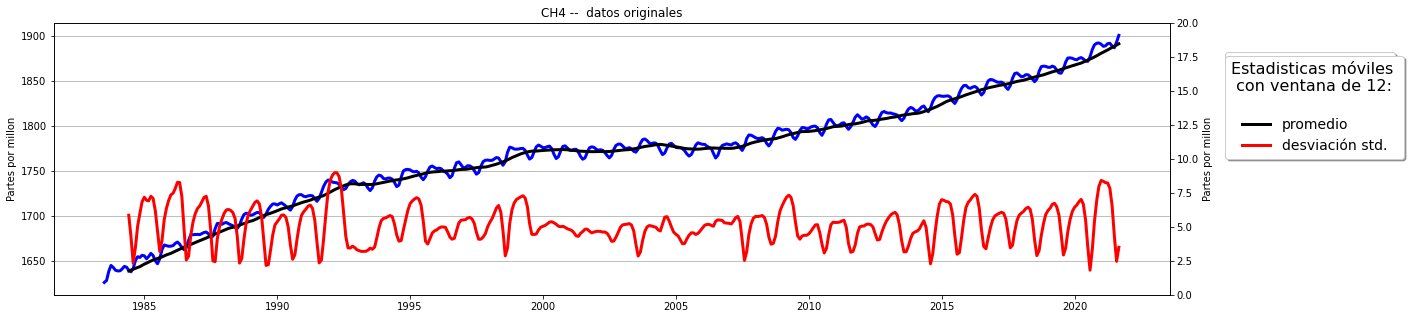


-- Test de Dickey-Fuller -- datos originales:
Test Statistic                   0.011126
p-value                          0.959443
#Lags Used                      16.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


In [15]:
# Estudio de la estacionaridad para los datos de CH4:
test_stacionary(data_mensual,"CH4",12, "datos originales","no")

-- SF6 --> datos originales:



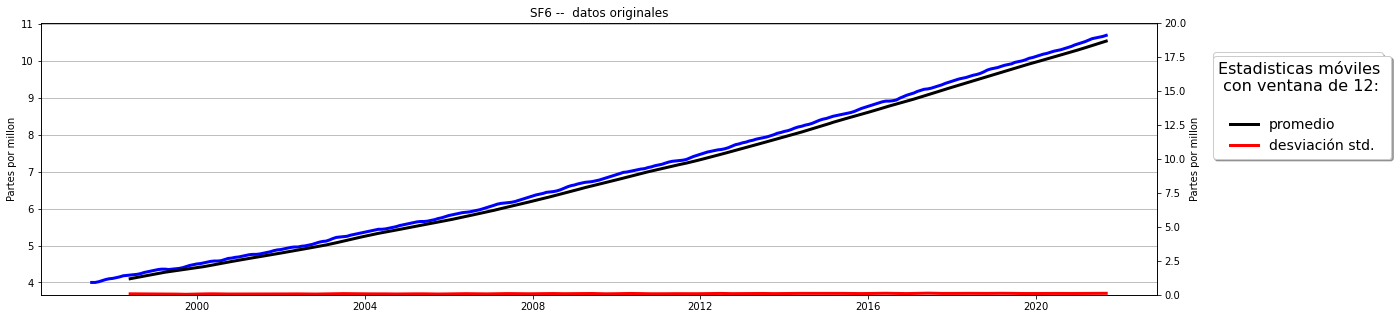


-- Test de Dickey-Fuller -- datos originales:
Test Statistic                   3.389398
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [16]:
# Estudio de la estacionaridad para los datos de SF6:
test_stacionary(data_mensual,"SF6",12, "datos originales","no")

** Ninguna de las series temporales son estacionarias. Se aprecia una clara tendencia ascendente dependiente del tiempo

#### Conversión serie en estacionaria

Para ello vamos a probar diferentes métodos:

<ol>
    <li> Eliminación de la tendencia: Suavizado de los datos, usamos estos dos métodos:
        <ol>
            <li>método de medias móviles</li>
            <li>método de medias móviles ponderadas exponencialmente  </li>
        </ol>
    </li>
    <li> Eliminación de la tendencia y/o estacionalidad
        <ol>
            <li>Differencing: Usamos la diferencia entre un punto y su valor anterior.</li>
            <li>Decomposición: Usamos la descomposición estacional usando los promedios móviles que proporciona la función <code>seasonal_decompose</code> de statsmodels</li>
        </ol>
    </li>
    
</ol>

En todos los casos primero hacemos una transformación logaritmica de los datos. 

** En los siguientes pasos vamos aplicar estos métodos y vamos a hacer el estudio de estacionaridad.

##### -- Eliminación tendencia:

-- CO2 --> eliminación tendencia:



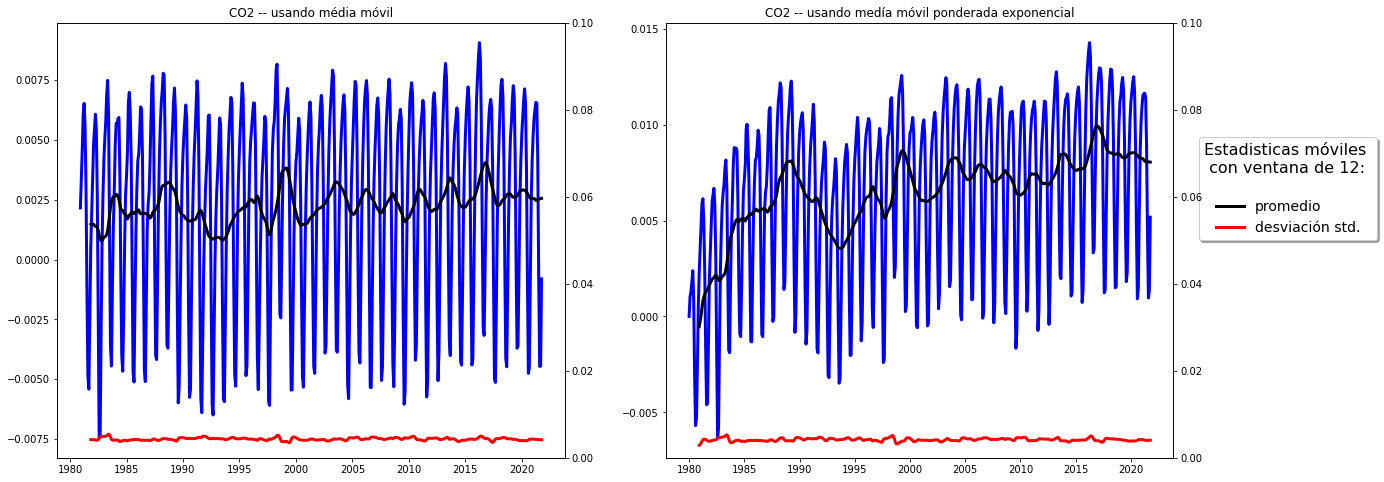


-- Test de Dickey-Fuller (médias móviles):
Test Statistic                  -4.691895
p-value                          0.000087
#Lags Used                      18.000000
Number of Observations Used    472.000000
Critical Value (1%)             -3.444281
Critical Value (5%)             -2.867683
Critical Value (10%)            -2.570042
dtype: float64

-- Test de Dickey-Fuller (médias móviles ponderadas exponencialmente):
Test Statistic                  -3.211666
p-value                          0.019319
#Lags Used                      18.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64


In [17]:
# Test de estacionalidad para CO2 usando la media móvil y la media móvil ponderada exponencialmente

data_avg_mov_CO2,data_avg_mov_exp_CO2=test_stacionary(data_mensual,"CO2",12,"eliminación tendencia","yes") # Estudio de la estacionaridad

-- N2O --> eliminación tendencia:



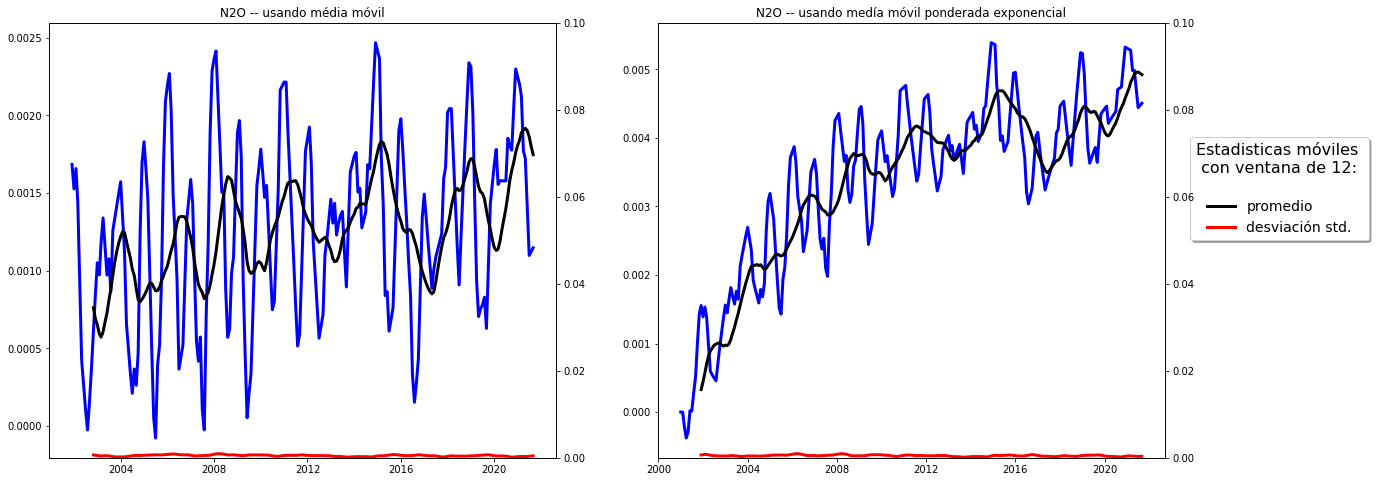


-- Test de Dickey-Fuller (médias móviles):
Test Statistic                  -4.611255
p-value                          0.000123
#Lags Used                      13.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64

-- Test de Dickey-Fuller (médias móviles ponderadas exponencialmente):
Test Statistic                  -1.904904
p-value                          0.329758
#Lags Used                      13.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [18]:
# Test de estacionalidad para N2O usando la média móvil y la media móvil ponderada exponencialmente

data_avg_mov_N2O,data_avg_mov_exp_N2O=test_stacionary(data_mensual,"N2O",12,"eliminación tendencia","yes") # Estudio de la estacionaridad

-- CH4 --> eliminación tendencia:



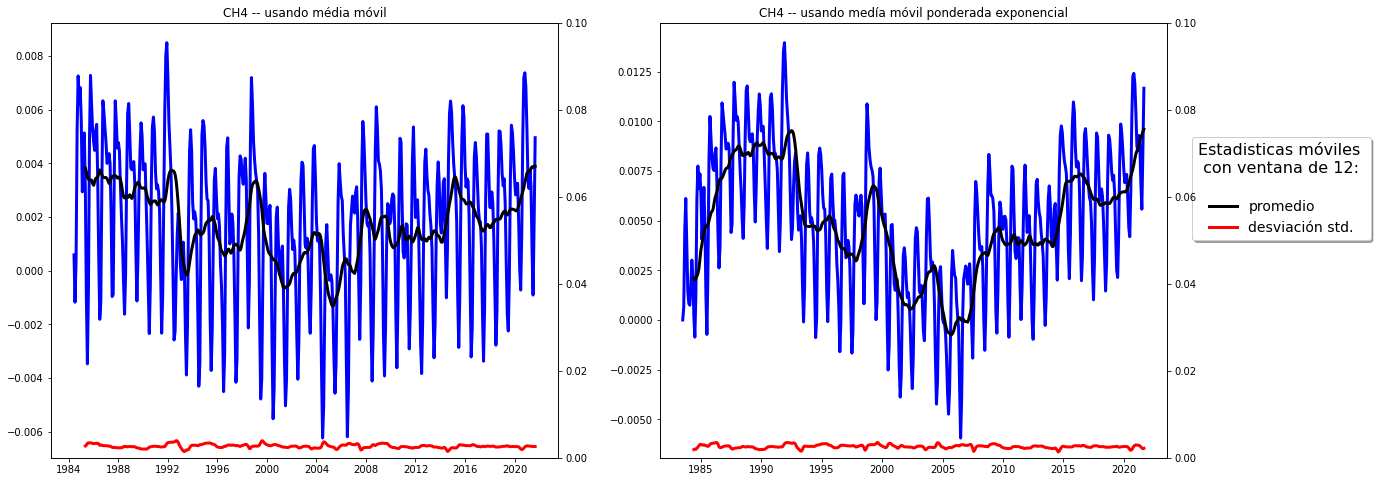


-- Test de Dickey-Fuller (médias móviles):
Test Statistic                  -2.576109
p-value                          0.098036
#Lags Used                      18.000000
Number of Observations Used    429.000000
Critical Value (1%)             -3.445685
Critical Value (5%)             -2.868301
Critical Value (10%)            -2.570371
dtype: float64

-- Test de Dickey-Fuller (médias móviles ponderadas exponencialmente):
Test Statistic                  -2.118180
p-value                          0.237268
#Lags Used                      16.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


In [19]:
# Test de estacionalidad para CH4 usando la média móvil y la media móvil ponderada exponencialmente

data_avg_mov_CH4,data_avg_mov_exp_CH4=test_stacionary(data_mensual,"CH4",12,"eliminación tendencia","yes") 

-- SF6 --> eliminación tendencia:



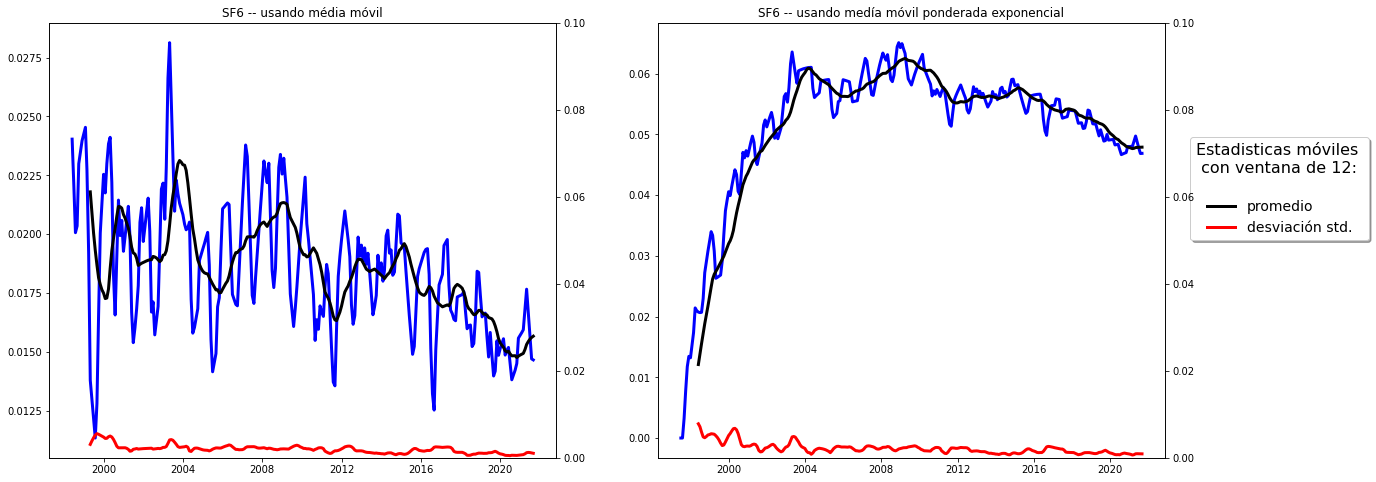


-- Test de Dickey-Fuller (médias móviles):
Test Statistic                  -1.757613
p-value                          0.401699
#Lags Used                      16.000000
Number of Observations Used    263.000000
Critical Value (1%)             -3.455461
Critical Value (5%)             -2.872593
Critical Value (10%)            -2.572660
dtype: float64

-- Test de Dickey-Fuller (médias móviles ponderadas exponencialmente):
Test Statistic                  -2.781465
p-value                          0.060971
#Lags Used                      15.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [20]:
# Test de estacionalidad para SF6 usando la média móvil y la media móvil ponderada exponencialmente

data_avg_mov_SF6,data_avg_mov_exp_SF6=test_stacionary(data_mensual,"SF6",12,"eliminación tendencia","yes")

##### -- Eliminación tendencia y estacionalidad:


In [21]:
# Función usando el método de descomposición y differencing + test de estacionalidad

def test_stacionary_tend_estacio(df,gas,ventana,metodo):
    print("-- "+str(gas)+" --> "+str(metodo)+":\n")
    
    df_log=np.log(df[["CO2","N2O","CH4","SF6"]])
    
    # Calculo de la descomposición de los datos
    decomposition=seasonal_decompose(df_log[gas].dropna(axis=0))
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(df[gas],label="datos originales")
    ax.legend(loc="best")
    ax = fig.add_subplot(2, 2, 2)
    ax.plot(seasonal,label="Estacionalidad")
    ax.legend(loc=(1.01,0.5))
    ax = fig.add_subplot(2, 2, 3)
    ax.plot(trend,label="Tendencia")
    ax.legend(loc="best")
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(residual,label="Residuos")
    ax.legend(loc=(1.01,0.5))
    plt.show()
    
    # Cálculo del Differencing
    df_diff=df_log-df_log.shift()
    
    # Cálculo de las propiedades estadíscias móviles
    df_temp_desc=residual # descomposición
    df_mov_avg_desc=df_temp_desc.rolling(ventana).mean()
    df_mov_std_desc=df_temp_desc.rolling(ventana).std()
    
    df_temp_diff=df_diff # Differencing
    df_mov_avg_diff=df_temp_diff.rolling(ventana).mean()
    df_mov_std_diff=df_temp_diff.rolling(ventana).std()
    
    # Representación de los datos junto con la estadística móvil
    
    # Datos de la descomposición
    fig = plt.figure(figsize=(20,8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2=ax1.twinx()

    plot1=ax1.plot(residual,c='blue',label="datos mensuales",lw=3)
    plot2=ax1.plot(df_mov_avg_desc,"-",label="promedio",c="black",lw=3)
    plot3=ax2.plot(df_mov_std_desc,"-",label="desviación std.",c="red",lw=3)
    ax1.set_title(str(gas)+" -- descomposición")
    ax2.set_ylim((0,3))
    
    # Datos del Differencing
    ax1 = fig.add_subplot(1, 2, 2)
    ax2=ax1.twinx()   

    plot1=ax1.plot(df_diff[gas],c='blue',label="datos mensuales",lw=3)
    plot2=ax1.plot(df_mov_avg_diff[gas],"-",label="promedio",c="black",lw=3)
    plot3=ax2.plot(df_mov_std_diff[gas],"-",label="desviación std.",c="red",lw=3)
    ax1.set_title(str(gas)+" -- differencing")
    ax2.set_ylim((0,3))
    
    lns1 = plot1
    labs1 = [l.get_label() for l in lns1]
    lns2 = plot2+plot3
    labs2 = [l.get_label() for l in lns2]

    ax1.legend(lns1,labs1,loc=(1.05,0.8),fontsize=14, fancybox=True, shadow=True)
    ax2.legend(lns2,labs2,loc=(1.05,0.3),fontsize=14, fancybox=True, shadow=True)
    ax2.get_legend().set_title("Estadisticas móviles \n con ventana de "+str(ventana)+": \n",prop={'size':16})
    plt.show()
     
    # Test de Dickey-Fuller - descomposición de los datos:
    dftest = adfuller(residual.dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller - descomposición de los datos:")
    print(dfoutput)

    # Test de Dickey-Fuller - Differencing:
    dftest = adfuller(df_diff[gas].dropna(axis=0), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print("\n-- Test de Dickey-Fuller - differencing:")
    print(dfoutput)
    
    return trend,seasonal,residual,df_diff[gas],df_log[gas]

-- CO2 --> elimación tendencia y estacionalidad:



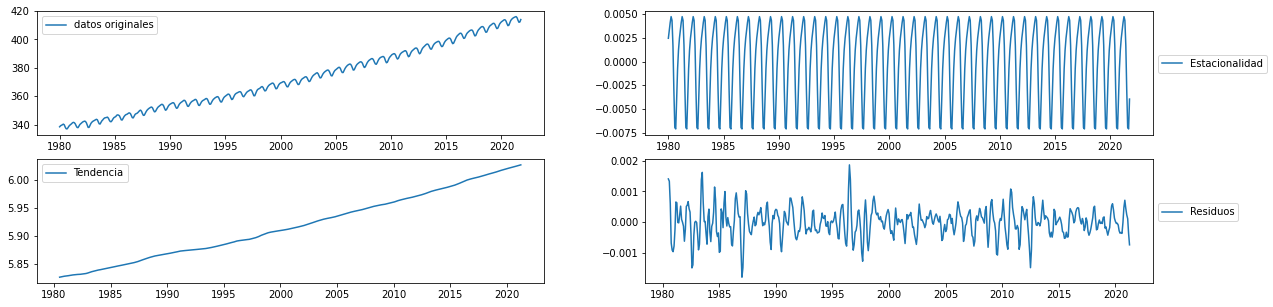

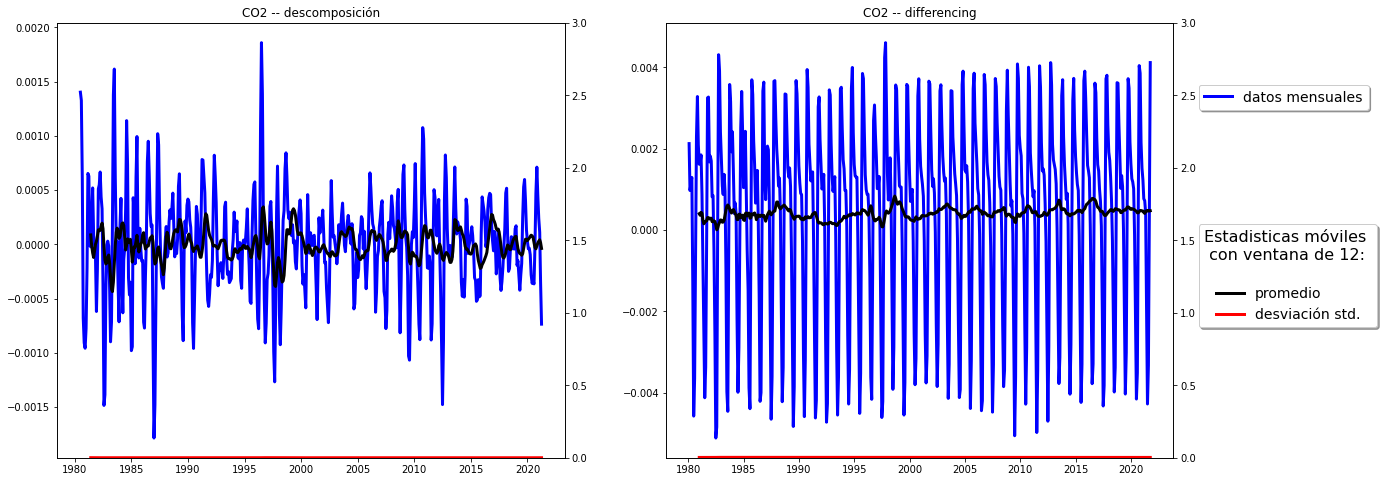


-- Test de Dickey-Fuller - descomposición de los datos:
Test Statistic                -7.786188e+00
p-value                        8.167993e-12
#Lags Used                     1.800000e+01
Number of Observations Used    4.710000e+02
Critical Value (1%)           -3.444310e+00
Critical Value (5%)           -2.867696e+00
Critical Value (10%)          -2.570049e+00
dtype: float64

-- Test de Dickey-Fuller - differencing:
Test Statistic                  -5.011924
p-value                          0.000021
#Lags Used                      18.000000
Number of Observations Used    482.000000
Critical Value (1%)             -3.443990
Critical Value (5%)             -2.867555
Critical Value (10%)            -2.569974
dtype: float64


In [22]:
# Estudio estacionaridad usando la descomposición de los datos y differencing
trend_CO2,seasonal_CO2,residual_CO2,data_diff_CO2,data_log_CO2=test_stacionary_tend_estacio(data_mensual,"CO2",12,"elimación tendencia y estacionalidad")

-- N2O --> elimación tendencia y estacionalidad:



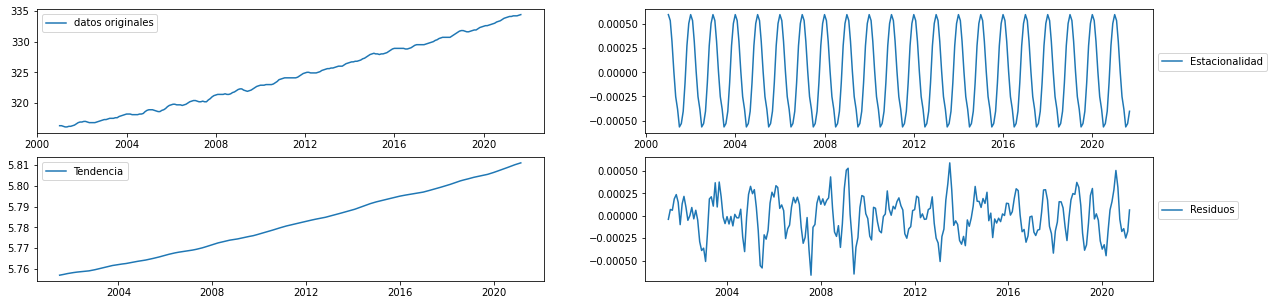

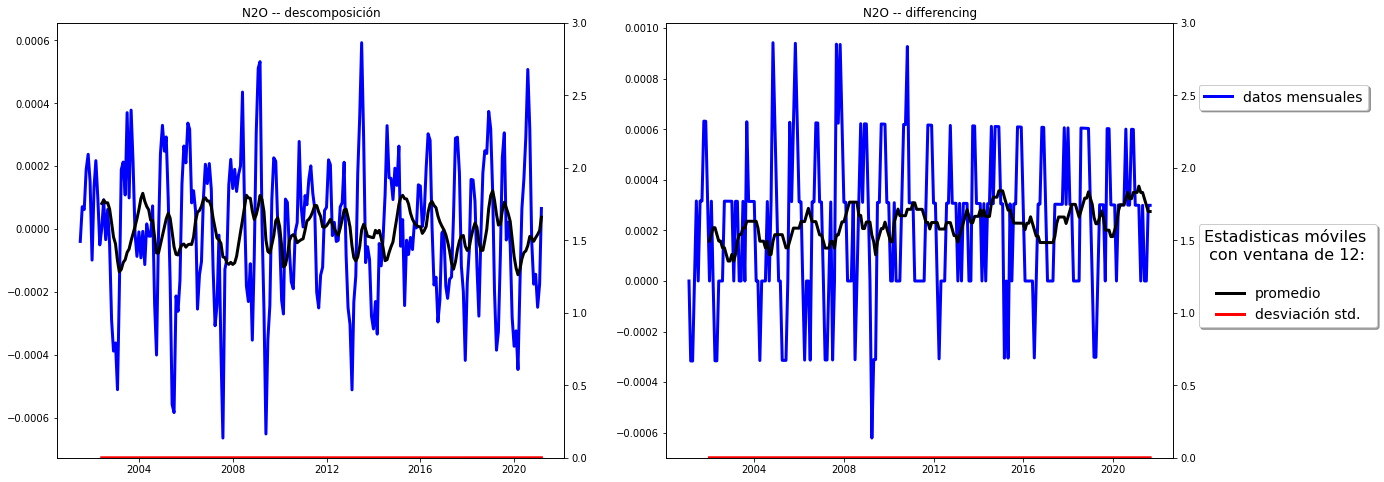


-- Test de Dickey-Fuller - descomposición de los datos:
Test Statistic                -7.128422e+00
p-value                        3.569747e-10
#Lags Used                     1.000000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64

-- Test de Dickey-Fuller - differencing:
Test Statistic                  -3.366186
p-value                          0.012167
#Lags Used                      12.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


In [23]:
# Estudio estacionaridad usando la descomposición de los datos y differencing
trend_N2O,seasonal_N2O,residual_N2O,data_diff_N2O,data_log_N2O=test_stacionary_tend_estacio(data_mensual,"N2O",12,"elimación tendencia y estacionalidad")

-- CH4 --> elimación tendencia y estacionalidad:



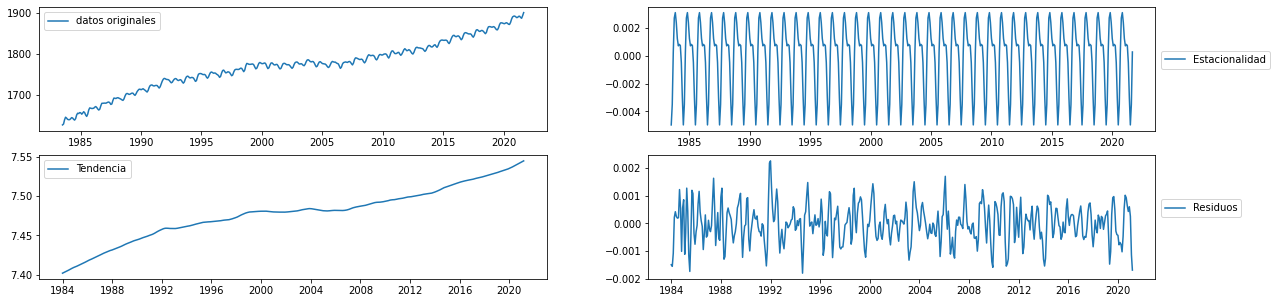

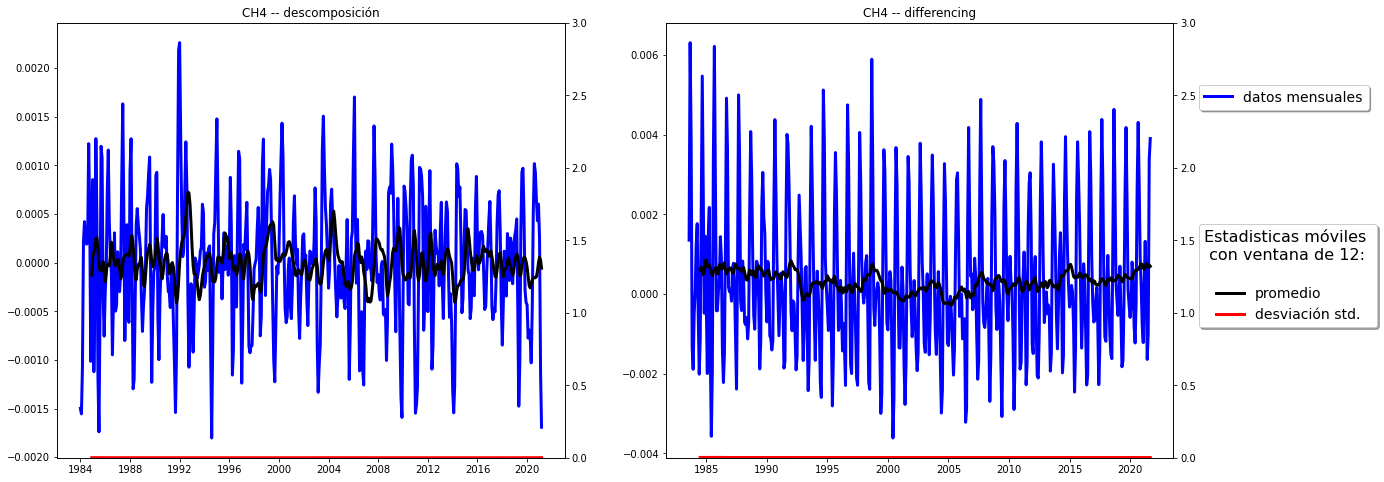


-- Test de Dickey-Fuller - descomposición de los datos:
Test Statistic                -7.354255e+00
p-value                        9.875076e-11
#Lags Used                     1.600000e+01
Number of Observations Used    4.300000e+02
Critical Value (1%)           -3.445649e+00
Critical Value (5%)           -2.868285e+00
Critical Value (10%)          -2.570363e+00
dtype: float64

-- Test de Dickey-Fuller - differencing:
Test Statistic                  -3.248254
p-value                          0.017356
#Lags Used                      15.000000
Number of Observations Used    442.000000
Critical Value (1%)             -3.445232
Critical Value (5%)             -2.868101
Critical Value (10%)            -2.570265
dtype: float64


In [24]:
# Estudio estacionaridad usando la descomposición de los datos y differencing
trend_CH4,seasonal_CH4,residual_CH4,data_diff_CH4,data_log_CH4=test_stacionary_tend_estacio(data_mensual,"CH4",12,"elimación tendencia y estacionalidad")

-- SF6 --> elimación tendencia y estacionalidad:



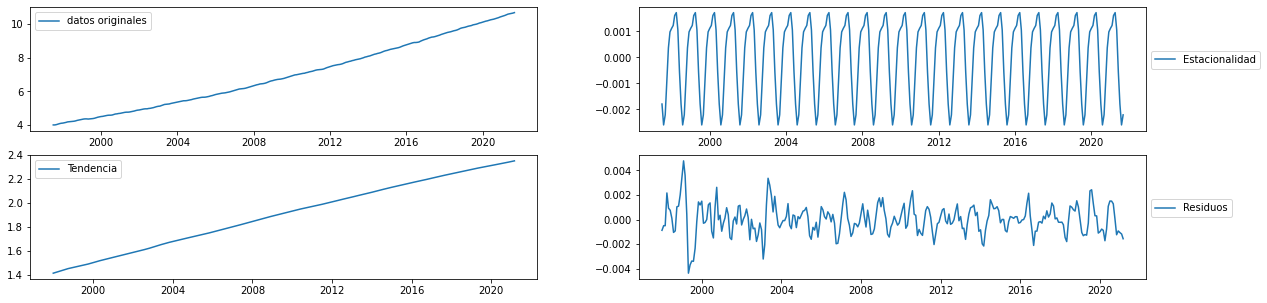

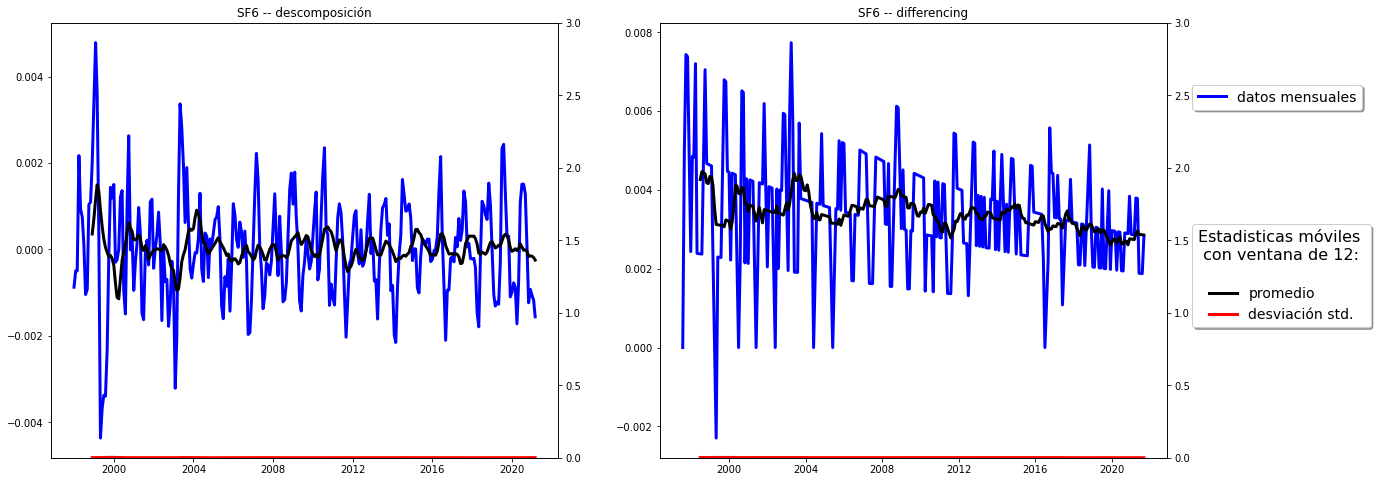


-- Test de Dickey-Fuller - descomposición de los datos:
Test Statistic                -8.140201e+00
p-value                        1.033083e-12
#Lags Used                     1.400000e+01
Number of Observations Used    2.640000e+02
Critical Value (1%)           -3.455365e+00
Critical Value (5%)           -2.872551e+00
Critical Value (10%)          -2.572638e+00
dtype: float64

-- Test de Dickey-Fuller - differencing:
Test Statistic                  -3.654188
p-value                          0.004806
#Lags Used                      14.000000
Number of Observations Used    275.000000
Critical Value (1%)             -3.454355
Critical Value (5%)             -2.872108
Critical Value (10%)            -2.572401
dtype: float64


In [25]:
# Estudio estacionaridad usando la descomposición de los datos y differencing
trend_SF6,seasonal_SF6,residual_SF6,data_diff_SF6,data_log_SF6=test_stacionary_tend_estacio(data_mensual,"SF6",12,"elimación tendencia y estacionalidad")

| nivel de confianza estacionaridad datos | CO2 | N2O | CH4 | SF6 |
|:-------------------:|:---:|:---:|:---:|:---:|
| Datos sin tratar | No estacionario | No estacionario | No estacionario | No estacionario |
| Sustrayendo medía móvil | 99% | 99% | 90% | No estacionario |
| Sustrayendo medía móvil ponderada exponencialmente | 95% | No estacionario | No estacionario | 90% |
| Descomposición de los datos | 99% | 99% | 99% | 99% |
| Differencing de los datos | 99% | 95% | 95% | 99% |

* En este caso vamos a usar el metodo de differencing para hacer el forecasting

#### Forecasting

Para hacer el modelado de nuestras series temporales vamos a usar el modelo ARICA(p,d,q).

In [26]:
# Determinación de los parámetros p y q del modelo

def val_p_q(data,gas):
    print("-- "+str(gas)+":\n")
    # ACF and PACF 
    lag_acf = acf(data.dropna(axis=0), nlags=20,fft=False)
    lag_pacf = pacf(data.dropna(axis=0), nlags=20, method='ols')

    # ACF
    plt.figure(figsize=(15,3))

    plt.subplot(121) 
    plt.plot(lag_acf,"*-")
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data_diff_CO2)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data_diff_CO2)),linestyle='--',color='gray')
    plt.title('Función de autocorrelación - determinar q')

    plt.subplot(122)
    plt.plot(lag_pacf,"*-")
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data_diff_CO2)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data_diff_CO2)),linestyle='--',color='gray')
    plt.title('Función de autocorrelación parcial - determinar p')
    plt.show()


-- CO2:



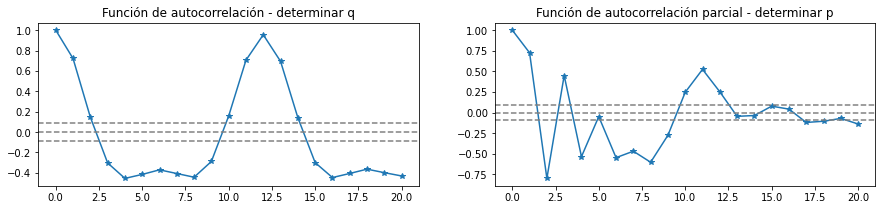

-- N2O:



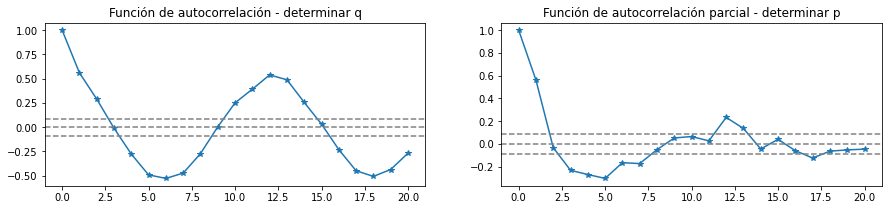

-- CH4:



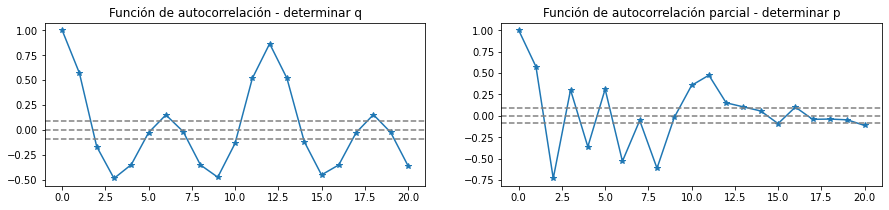

-- SF6:



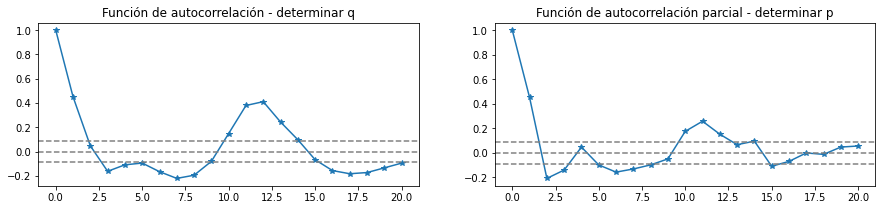

In [27]:
val_p_q(data_diff_CO2,"CO2")
val_p_q(data_diff_N2O,"N2O")
val_p_q(data_diff_CH4,"CH4")
val_p_q(data_diff_SF6,"SF6")

* Coeficientes que usamos para el modelo ARIMA despues de ver las funciones PACF y ACF. Usamos el primer valor que cruza el intervalo de confianza superior

| Coeficientes ARIMA | CO2 | N2O | CH4 | SF6 |
|:-------------------:|:---:|:---:|:---:|:---:|
| p | 2 | 2 | 2 | 2 |
| d | 1 | 1 | 1 | 1 |
| q | 3 | 3 | 2 | 2 |


In [28]:
# Función para aplicar los modelos de Forecasting

def forecasting(data,gas,p,d,q):
    print("-- "+str(gas)+":\n")
    
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(hspace=0.4, wspace=0.5)
    
    # Modelo autorregresión AR(p)
    q1=0
    p1=p
    model_AR=ARIMA(data.dropna(axis=0),order=(p1,d,q1))
    results_AR=model_AR.fit()
    temp1_AR=results_AR.fittedvalues-data # Calculamos la suma de residuos al cuadrado (mínimos cuadrados)
    RSS_AR=sum((temp1_AR.dropna(axis=0))**2)
    temp2_AR=(results_AR.fittedvalues-data.dropna(axis=0)**2)/len(data.dropna(axis=0)) # Error cuadrático médio
    RMSE_AR=np.sqrt(sum(temp2_AR.dropna(axis=0)))

    
    plt.subplot(311)
    plt.plot(data.dropna(axis=0),lw=6,label="datos")
    plt.plot(results_AR.fittedvalues[2:],color="red",lw=1.5,label="ajuste")
    plt.title("AR -- RSS={:.8f} -- RMSE={:.8f}".format(RSS_AR,RMSE_AR))
    plt.legend(loc=(1.02,0.5),fontsize=15)

    # Modelo medias móviles MA(q)
    q2=q
    p2=0
    model_MA=ARIMA(data.dropna(axis=0),order=(p2,d,q2))
    results_MA=model_MA.fit()
    temp1_MA=results_MA.fittedvalues-data.dropna(axis=0)
    RSS_MA=sum((temp1_MA.dropna(axis=0))**2)
    temp2_MA=(results_MA.fittedvalues-data.dropna(axis=0)**2)/len(data.dropna(axis=0))
    RMSE_MA=np.sqrt(sum(temp2_MA.dropna(axis=0)))
    
    plt.subplot(312)
    plt.plot(data.dropna(axis=0),lw=6,label="datos")
    plt.plot(results_MA.fittedvalues[2:],color="orange",lw=2,label="ajuste")
    plt.title("MA -- RSS={:.8f} -- RMSE={:.8f}".format(RSS_MA,RMSE_MA))
    plt.legend(loc=(1.02,0.5),fontsize=15)

    # Modelo autorresivo integrado de media móvil ARIMA(p,d,q)
    q3=q
    p3=p
    model_ARIMA=ARIMA(data.dropna(axis=0),order=(p3,d,q3))
    results_ARIMA=model_ARIMA.fit()
    temp1_ARIMA=results_ARIMA.fittedvalues-data.dropna(axis=0)
    RSS_ARIMA=sum((temp1_ARIMA.dropna(axis=0))**2)
    temp2_ARIMA=(results_ARIMA.fittedvalues-data.dropna(axis=0)**2)/len(data.dropna(axis=0))
    RMSE_ARIMA=np.sqrt(sum(temp2_ARIMA.dropna(axis=0)))

    plt.subplot(313)
    plt.plot(data.dropna(axis=0),lw=6,label="datos")
    plt.plot(results_ARIMA.fittedvalues[2:],color="chocolate",lw=2,label="ajuste")
    plt.title("ARIMA -- RSS={:.8f} -- RMSE={:.8f}".format(RSS_ARIMA,RMSE_ARIMA))
    plt.legend(loc=(1.02,0.5),fontsize=15)
    

    return RSS_AR,RSS_MA,RSS_ARIMA,results_AR.fittedvalues,results_MA.fittedvalues,results_ARIMA.fittedvalues

-- CO2:



/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/belen/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


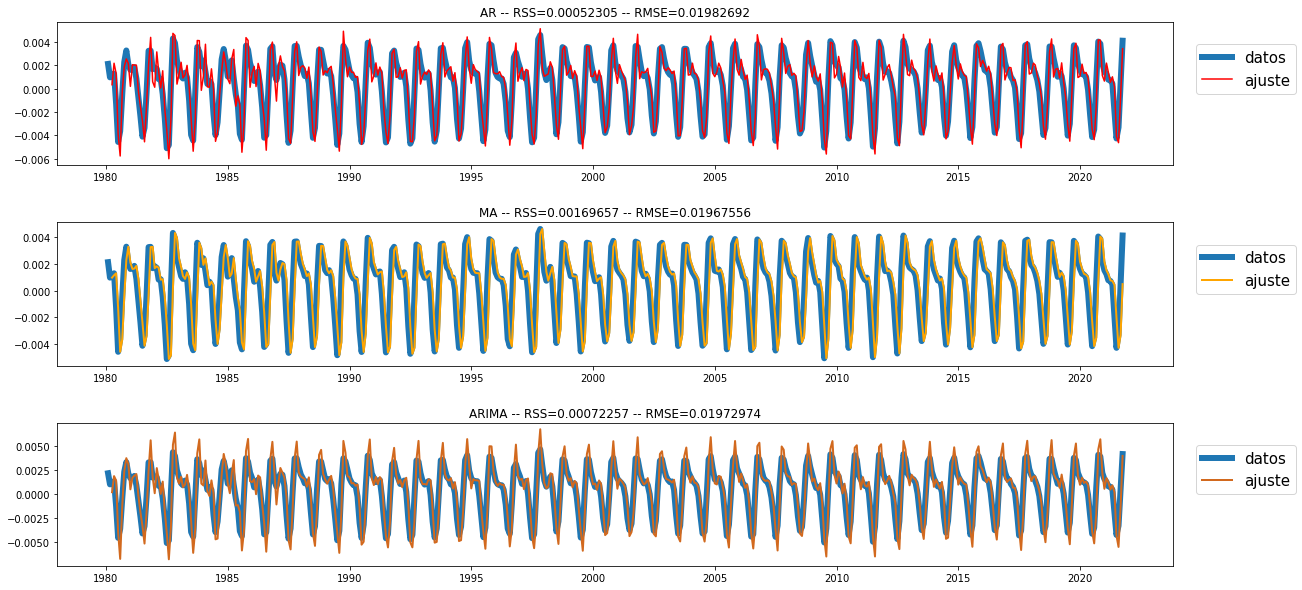

In [29]:
# Aplicamos los modelos de AR, MA y ARIMA a los datos de CO2
RSS_AR_CO2,RSS_MA_CO2,RSS_ARIMA_CO2,fit_AR_CO2,fit_MA_CO2,fit_ARIMA_CO2=forecasting(data_diff_CO2,"CO2",2,1,3)

-- N2O:



/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/belen/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


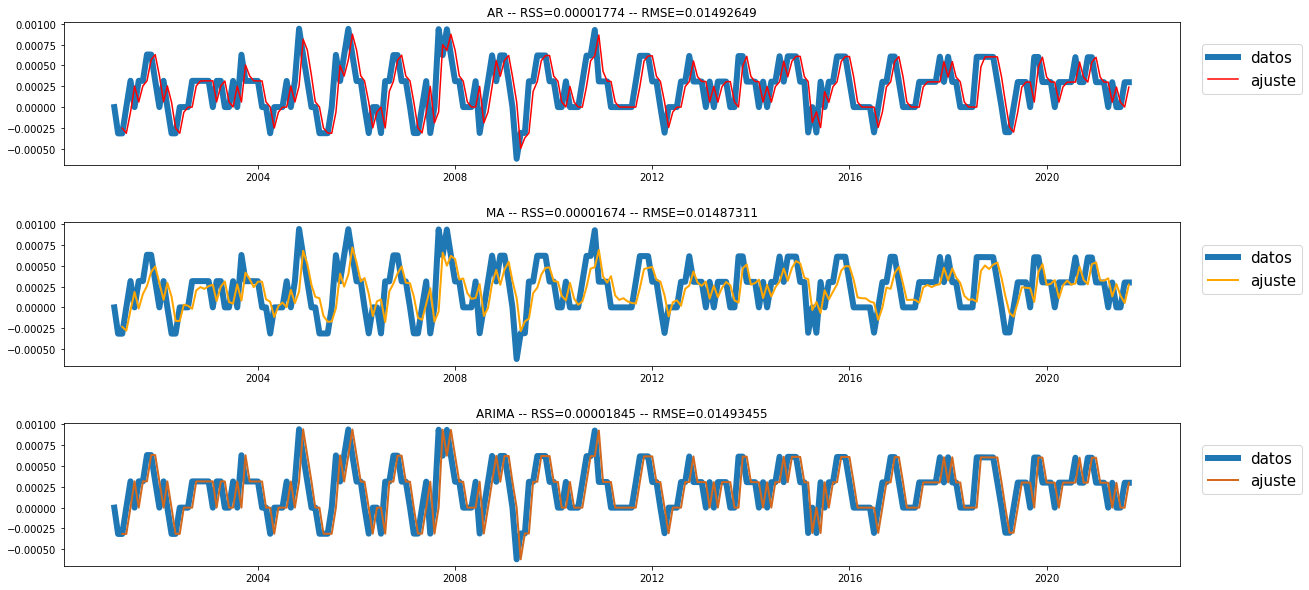

In [30]:
# Aplicamos los modelos de AR, MA y ARIMA a los datos de N2O
RSS_AR_N2O,RSS_MA_N2O,RSS_ARIMA_N2O,fit_AR_N2O,fit_MA_N2O,fit_ARIMA_N2O=forecasting(data_diff_N2O,"N2O",2,1,3)

-- CH4:



/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


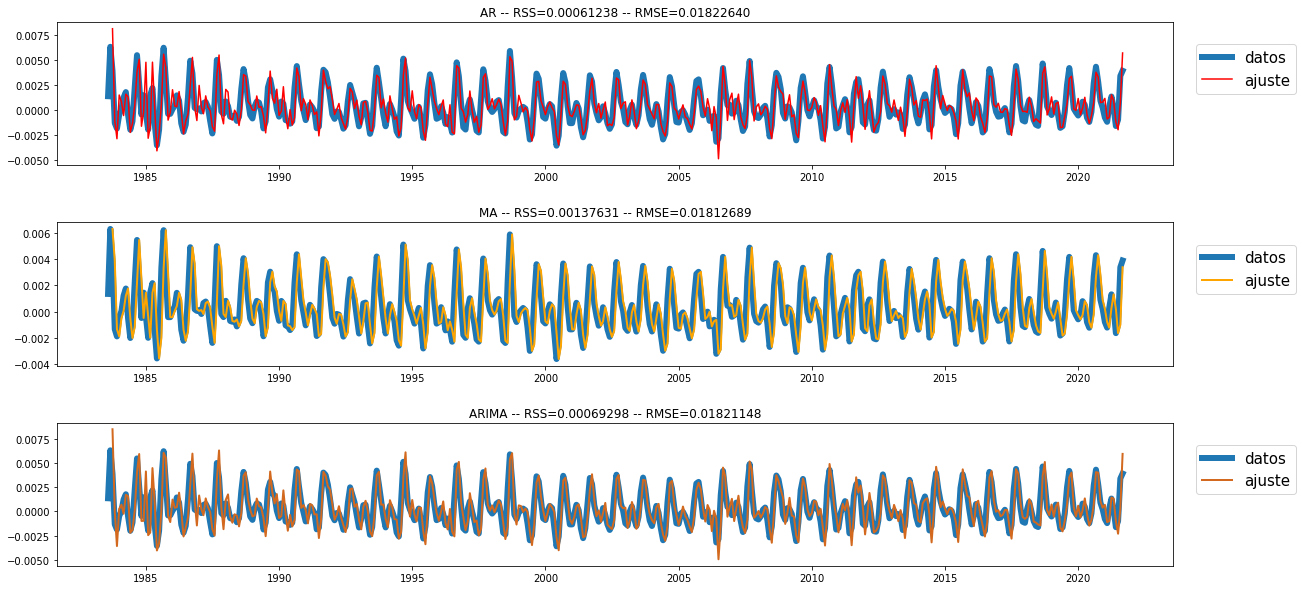

In [31]:
# Aplicamos los modelos de AR, MA y ARIMA a los datos de CH4
RSS_AR_CH4,RSS_MA_CH4,RSS_ARIMA_CH4,fit_AR_CH4,fit_MA_CH4,fit_ARIMA_CH4=forecasting(data_diff_CH4,"CH4",2,1,2)

-- SF6:



/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/belen/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


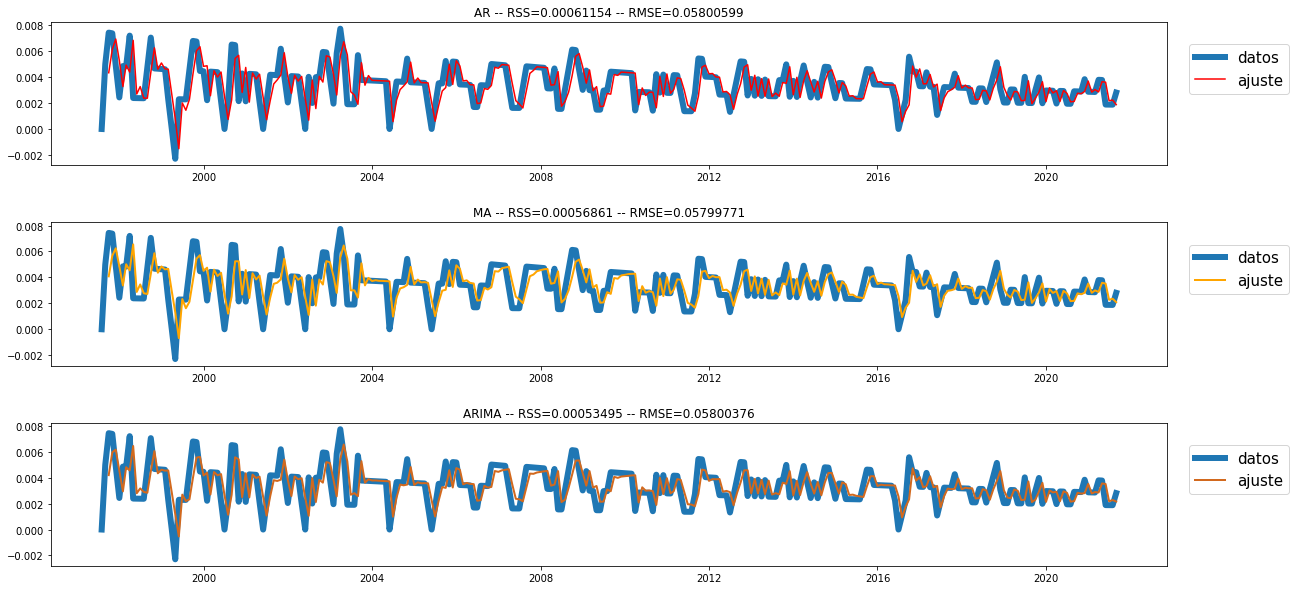

In [32]:
# Aplicamos los modelos de AR, MA y ARIMA a los datos de SF6
RSS_AR_SF6,RSS_MA_SF6,RSS_ARIMA_SF6,fit_AR_SF6,fit_MA_SF6,fit_ARIMA_SF6=forecasting(data_diff_SF6,"SF6",2,1,2)

| RSS | CO2 | N2O | CH4 | SF6 |
|:-------------------:|:---:|:---:|:---:|:---:|
| AR(p) | {{RSS_AR_CO2}} | {{RSS_AR_N2O}} | {{RSS_AR_CH4}} | {{RSS_AR_SF6}} |
| MA(q) | {{RSS_MA_CO2}} | {{RSS_MA_N2O}} | {{RSS_MA_CH4}} | {{RSS_MA_SF6}} |
| ARIMA(p,d,q) | {{RSS_ARIMA_CO2}} | {{RSS_ARIMA_N2O}} | {{RSS_ARIMA_CH4}} | {{RSS_ARIMA_SF6}} |

* Usamos el valor de los mínimos cuadrados para ver que modelo es mejor para cada una de nuestras series temporales.

- CO2: usamos AR(2)
- N2O: usamos MA(3)
- CH4: usamos AR(2)
- SF6: usamos ARIMA(2,1,1)

Por último sobre los datos predichos por el modelo vamos a invertir la transformación que hicimos para convertir los datos en estacionarios. Para invertir el differing de los datos logarítmicos (método usado para hacer los datos estacionarios), lo que hacemos es primero determinar la suma acumulada en el ínidice y luego agregarle el número base. 

#### - Inversión de la transformación de estacionaridad

In [33]:
# Función para invertir los cambios sobre los datos predichos por el modelo de forecasting
def back_values(data_fit,data_log,data,gas):
    
    print("-- "+str(gas)+" :\n")

    data_predictions=pd.Series(data_fit.dropna(axis=0),copy=True)
    data_predictions_comsum=data_predictions.cumsum() # calcula la suma acumulada

    # Creamos una Serieframe en el que el número base es el valor de todas las posiciones (mismos indices que los datos logaritmicos)
    data_predictions_log = pd.Series(data_log.dropna(axis=0).iloc[0], index=data_log.dropna(axis=0).index) 
    data_predictions_log = data_predictions_log.add(data_predictions_comsum,fill_value=0) # Sumamos la suma acumulada al número base

    predictions = np.exp(data_predictions_log) # Invertimos el logaritmo

    #Representamos los datos originales y los predichos por el modelo después de invertir los cambios
    plt.figure(figsize=(20,5))
    plt.plot(data[gas].dropna(axis=0),lw=5)
    plt.plot(predictions,lw=2,c="red")
    plt.title('RMSE: %.4f'% np.sqrt(sum((predictions-data[gas].dropna(axis=0))**2)/len(data[gas].dropna(axis=0))))
    plt.show()

-- CO2 :



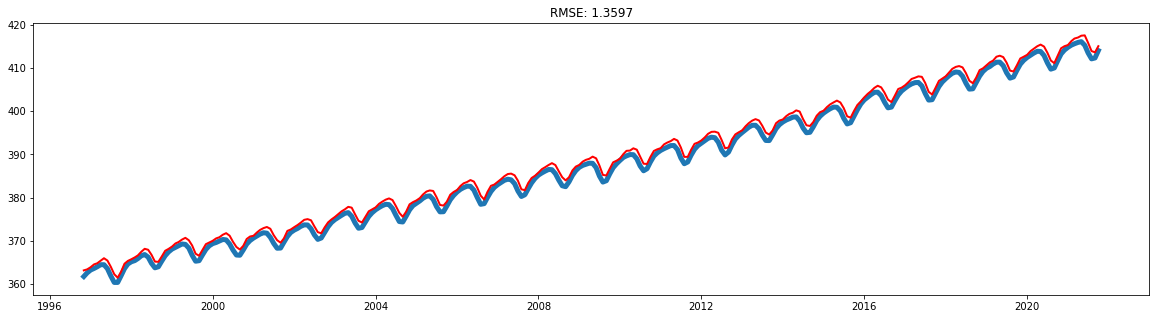

In [34]:
# Comparación datos originales y predichos por el modelo para el CO2
back_values(fit_AR_CO2[-300:],data_log_CO2[-300:],data_mensual[-300:],"CO2")

# No representamos todos los datos para poder apreciar mejor si hay diferencias entre los datos del modelo y los 
# originales.

-- N2O :



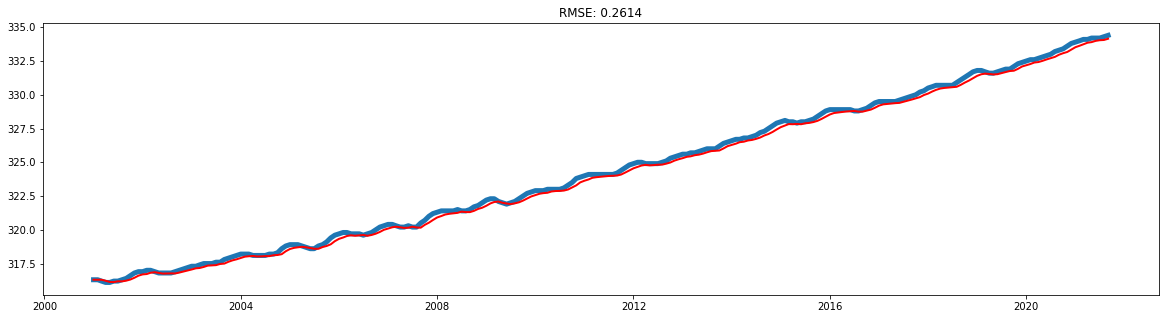

In [35]:
# Comparación datos originales y predichos por el modelo para el N2O
back_values(fit_MA_N2O[:],data_log_N2O[:],data_mensual[:],"N2O")

-- CH4 :



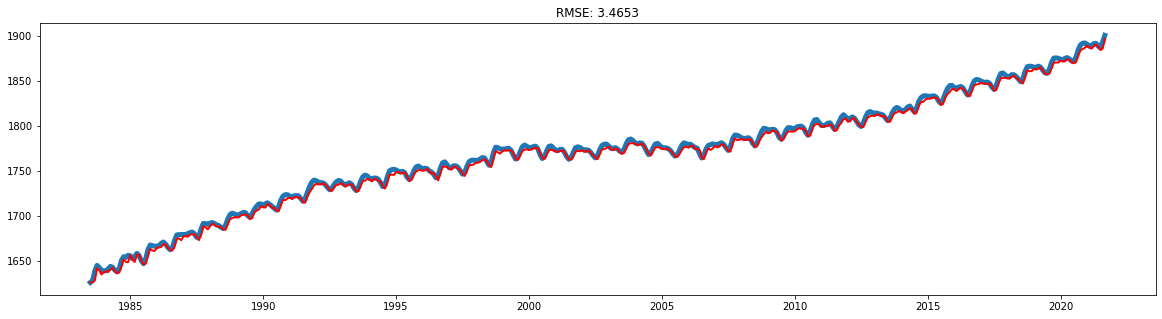

In [36]:
# Comparación datos originales y predichos por el modelo para el CH4
back_values(fit_AR_CH4[:],data_log_CH4[:],data_mensual[:],"CH4")

-- SF6 :



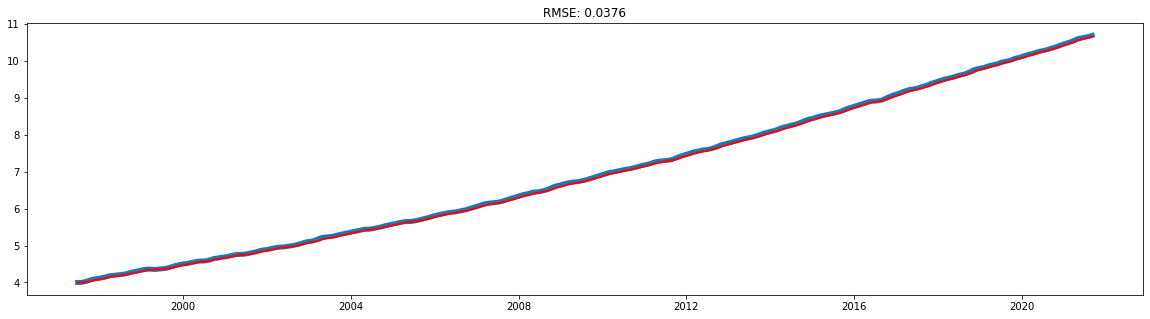

In [37]:
# Comparación datos originales y predichos por el modelo para el SF6
back_values(fit_ARIMA_SF6[:],data_log_SF6[:],data_mensual[:],"SF6")